# Segmentation Network Example

Builds a segmentation neural network with TensorFlow 2.0 eager execution ([code]())

### Code Overview:
1. Import libraries
2. Import data for training and testing 
3. Define Model
4. Define Loss function
5. Define Training procedure
6. Run Model code 
    a. Train model
    b. Test model
7. Plot accuracy of results

## Example Code

import libraries

In [1]:
from __future__ import absolute_import, division, print_function
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib
import matplotlib.pyplot as plt

Define DataGenerator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cairo

WIDTH = 128
HEIGHT = 128
CHANNELS = 3

class DataGenerator:

    def __init__(self):
        self.size = 1000
        self.ratio = 0.8
        
        self.WIDTH = WIDTH
        self.HEIGHT = HEIGHT
        self.CHANNELS = CHANNELS
        
        self.generate();

    def generate_image(self):
        ''' Randomly generates an image with random boxes '''    

        data = np.zeros( (HEIGHT,WIDTH, 4), dtype=np.uint8 ) 
        surface = cairo.ImageSurface.create_for_data( data, cairo.FORMAT_ARGB32, WIDTH, HEIGHT )
        ctx = cairo.Context( surface )

        ctx.scale (WIDTH, HEIGHT) # Normalizing the canvas
        ctx.set_source_rgb(0, 0, 0)
        ctx.rectangle (0, 0, 1, 1)  # Rectangle(x0, y0, x1, y1) 
        ctx.fill()

        # Create random colored boxes
        for _ in range(50):
            rc = np.random.rand(3)
            ctx.set_source_rgb(rc[0], rc[1], rc[2])

            r = np.random.rand(2)
            ctx.translate (r[0], r[1])      # Changing the current transformation matrix
            ctx.rectangle (0, 0, 0.1, 0.1)  # Rectangle(x0, y0, x1, y1)
            ctx.fill()
            ctx.translate (-r[0], -r[1])    # Changing the current transformation matrix

        # Create a randomly placed red box
        ctx.set_source_rgb(0, 0, 1)
        r = np.random.rand(2)
        ctx.translate (r[0], r[1])      # Changing the current transformation matrix
        ctx.rectangle (0, 0, 0.1, 0.1)  # Rectangle(x0, y0, x1, y1)
        ctx.fill()
        ctx.translate (-r[0], -r[1])

        img = data[:,:,0:3]
        return img;

    def whiten_data(self, features):
        """ whiten dataset - zero mean and unit standard deviation """
        features = np.reshape(features, (self.size, WIDTH * HEIGHT * CHANNELS))
        features = (np.swapaxes(features,0,1) - np.mean(features, axis=1)) / np.std(features, axis=1)
        features = np.swapaxes(features,0,1)
        features = np.reshape(features, (self.size, WIDTH, HEIGHT, CHANNELS))
        #features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
        return features

    def unwhiten_img(self, img): 
        """ remove whitening for a single image """ 
        img = np.reshape(img, (WIDTH * HEIGHT * CHANNELS))
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) 
        img = np.reshape(img, (WIDTH, HEIGHT, CHANNELS))
        return img

    def generate(self):
        ''' Generates a randomly generated dataset '''
        img = self.generate_image()
        self.data = np.stack( (img, self.generate_image()))
        for _ in range(self.size - 2):
            img = self.generate_image()
            self.data = np.concatenate( (self.data, img[None,:]), axis=0)
        
        # Generate truth data
        threshold = [200, 0, 0]
        self.label = np.all(np.greater_equal(self.data, threshold), axis=3) * 1.0;
        self.label = np.reshape(self.label, (self.size, WIDTH, HEIGHT, 1))
        self.label = np.concatenate( (1 - self.label, self.label), axis=3) # Index 0: Incorrect, Index 1: Correct

        # Setup data 
        self.data = self.whiten_data(self.data)

        # Split data into test/training sets
        index = int(self.ratio * len(self.data)) # Split index
        self.x_train = self.data[0:index, :].astype(np.float32)
        self.y_train = self.label[0:index].astype(np.float32)
        self.x_test = self.data[index:,:].astype(np.float32)
        self.y_test = self.label[index:].astype(np.float32)

    def show(self, index):
        ''' Show a data slice at index'''
        img = self.unwhiten_img( self.data[index] )
        plt.imshow(img)
        plt.show()

    def show_label(self, index):
        ''' Show a truth data slice at index'''
        img = self.label[index]
        plt.imshow(img[:,:,0], cmap='gray')
        plt.show()  
        plt.imshow(img[:,:,1], cmap='gray')
        plt.show()  

    def print(self):
        print("Data Split: ", self.ratio)
        print("Train => x:", self.x_train.shape, " y:", self.y_train.shape)
        print("Test  => x:", self.x_test.shape, " y:", self.y_test.shape)

    def next_batch(self, batch_size):
        ''' Retrieves the next batch for a given batch size '''
        length = self.x_train.shape[0]
        indices = np.random.randint(0, length, batch_size) # Grab batch_size values randomly
        return [self.x_train[indices], self.y_train[indices]]


Generate Dataset

In [3]:
# Generate Dataset
data = DataGenerator()
data.print()

Data Split:  0.8
Train => x: (800, 128, 128, 3)  y: (800, 128, 128, 2)
Test  => x: (200, 128, 128, 3)  y: (200, 128, 128, 2)


Set Training and Network Parameters

In [4]:
# Training Parameters
num_epochs = 10
display_step = 1
batch_size = 32

# Network Parameters
WIDTH = data.WIDTH; HEIGHT = data.HEIGHT; CHANNELS = data.CHANNELS
NUM_INPUTS = WIDTH * HEIGHT * CHANNELS
NUM_OUTPUTS = 2

Define Model

In [5]:
# Network Architecture
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.c1 = Conv2D(32, (3, 3), padding="same", activation=tf.nn.relu)
        self.c2 = Conv2D(32, (3, 3), padding="same", activation=tf.nn.relu)
        self.fout = Conv2D(NUM_OUTPUTS, (1, 1), padding="same", activation=tf.nn.softmax)

    def call(self, x):
        x = self.c1(x)
        x = self.c2(x)
        return self.fout(x)

Define Train

In [6]:
@tf.function
def train(model, inputs, outputs):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss_value = loss(predictions, outputs)
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    train_loss(loss_value)

Define Test

In [7]:
@tf.function
def test(model, inputs, outputs):
    predictions = model(inputs)
    test_accuracy(outputs, predictions)

Set Losses and Optimizers 

In [8]:
model = Model()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

Train model

In [9]:
out = []
epochs = range(num_epochs)
for epoch in epochs:
    x_train, y_train = data.next_batch(batch_size)
    train(model, x_train, y_train)

    test(model, data.x_test, data.y_test)
    
    out.append([epoch, test_accuracy.result()])

    if(epoch % display_step == 0):
        print('Epoch %2d: training loss=%2.5f test accuracy=%2.5f' % 
            (epoch, train_loss.result(), test_accuracy.result()))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    test_accuracy.reset_states()

Epoch  0: training loss=8.69286 test accuracy=0.26189
Epoch  1: training loss=8.12585 test accuracy=0.87214
Epoch  2: training loss=7.57019 test accuracy=0.91337
Epoch  3: training loss=6.99313 test accuracy=0.91808
Epoch  4: training loss=6.47154 test accuracy=0.92504
Epoch  5: training loss=5.98942 test accuracy=0.92508
Epoch  6: training loss=5.55857 test accuracy=0.92508
Epoch  7: training loss=5.00737 test accuracy=0.92508
Epoch  8: training loss=4.72359 test accuracy=0.92508
Epoch  9: training loss=4.28448 test accuracy=0.92508


Plot Results

(200, 128, 128, 2)


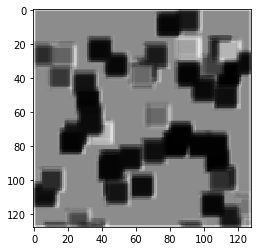

In [20]:
predictions = model(data.x_test)
print(predictions.shape)
plt.imshow(predictions[0,:,:,1], cmap='gray')

(128, 128)


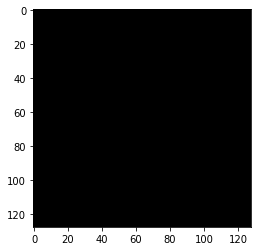

In [25]:
_ = predictions[0,:,:,1]
print(_.shape)
_ = np.greater(_, np.ones((128, 128)))
plt.imshow(_, cmap='gray')

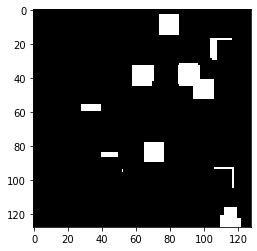

In [21]:
plt.imshow(data.y_test[0][:,:,1], cmap='gray')

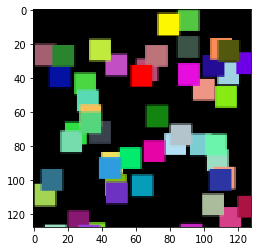

In [18]:
_ = data.unwhiten_img(data.x_test[0])
plt.imshow(_)